In [1]:
import mrcfile
import os
import numpy
from matplotlib import pyplot as plt
import numpy as np
from PIL import Image
from tqdm import tqdm
import pickle
from sklearn.decomposition import PCA


### Construct dataset

In [16]:
def get_files_of_type_from_path(fpath, fext):
    '''
    Gets a list of all paths with a particular extension (fext) given a path (fpath)
    '''
    data_file_paths = []
    for file in os.listdir(fpath):
        if file.endswith(fext):
            data_file_paths.append(os.path.join(fpath, file))
    return data_file_paths

def load_paths_into_array(paths):
    '''
    Given a list of paths (paths) of .pkl files of numpy arrays,
    return a list of numpy arrays
    '''
    arrs = []
    for p in paths:
        arrs.append(np.load(p, allow_pickle=True))
    return arrs


In [17]:
# # Data path
data_path = '../data/'

# # Paths to store good/bad .pkl files
good_path_out = os.path.join(data_path, 'dataset0/side')
bad_path_out = os.path.join(data_path, 'dataset0/none')

### Look at mean and std dev of classes

In [18]:
# Make dict of paths
data_paths = {'good': get_files_of_type_from_path(good_path_out, '.pkl'),  
              'bad': get_files_of_type_from_path(bad_path_out, '.pkl')}

# Load 
data = {'good': load_paths_into_array(data_paths['good']),
        'bad': load_paths_into_array(data_paths['bad'])}

# Stack 
arr_good = np.stack(data['good'],axis=0)
arr_bad =  np.stack(data['bad'],axis=0)

# Get average
arr_good_mean = np.mean(arr_good, axis=0)
arr_bad_mean = np.mean(arr_bad, axis=0)

# Get standard deviation
arr_good_std = np.std(arr_good, axis=0)
arr_bad_std = np.std(arr_bad, axis=0)

In [19]:
arr_stat_imgs = [arr_good_mean, arr_good_std, arr_bad_mean, arr_bad_std]
arr_stat_imgs_stack = np.stack(arr_stat_imgs, axis=0)
clim = [np.amin(arr_stat_imgs), np.amax(arr_stat_imgs)]

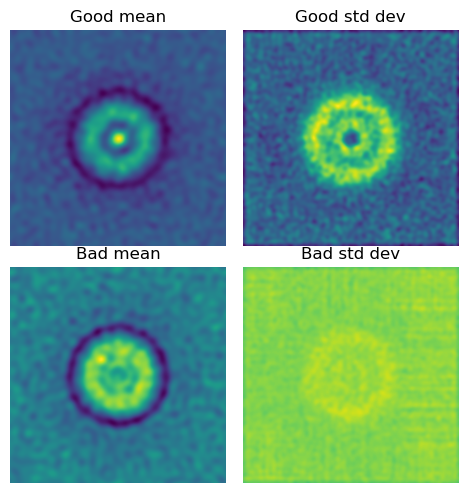

In [20]:
f, axarr = plt.subplots(2,2, figsize=[6,6], dpi= 100, gridspec_kw = {'wspace':0.0, 'hspace':0.1})
titles = ['Good mean', 'Good std dev', 'Bad mean', 'Bad std dev']
for i, ax in enumerate(f.get_axes()):
    ax.imshow(arr_stat_imgs[i])
    ax.axis('off')
    ax.set_title(titles[i])
for im in plt.gca().get_images():
    im.set_clim(clim)

### Do PCA

In [21]:
# Use all data
arr_all =  np.stack(data['good']+data['bad'],axis=0)

# Get average
arr_all_mean = np.mean(arr_all, axis=0)

# Get standard deviation
arr_all_std = np.std(arr_all, axis=0)

# Normalise
arr_all_norm = (arr_all-arr_all_mean)/np.sqrt(arr_all_std)

In [22]:
# Fit PCA
n_components = 9
arr_pca = PCA(n_components=n_components, svd_solver='randomized', whiten='True')
arr_all_flat = arr_all_norm.reshape(arr_all_norm.shape[0], arr_all_norm.shape[1]*arr_all_norm.shape[2])
arr_pca.fit(arr_all_flat)

PCA(n_components=9, svd_solver='randomized', whiten='True')

In [23]:
# Compute projection onto each category
def proj_onto_components(vectors, pca_comps, use_abs_sq=False):
    '''
    vectors should be a 2D numpy array of size [P, M]
    pca_comps should be a 2D numpy array of size [N, M]
    returns [N, P] array
    '''
    m = np.matmul(pca_comps, vectors.T)
    if use_abs_sq:
        m = np.square(m)
    return m

def avg_proj_onto_components(vectors, pca_comps, use_abs_sq=False):
    '''
    vectors should be a 2D numpy array of size [P, M]
    pca_comps should be a 2D numpy array of size [N, M]
    '''
    m = proj_onto_components(vectors, pca_comps, use_abs_sq=use_abs_sq)
    return np.mean(m, axis=1), np.std(m, axis=1)

def flatten_stack(arr):
    return arr.reshape(arr.shape[0], -1)

In [24]:
avg_good, std_good = avg_proj_onto_components(flatten_stack(np.stack(data['good'], axis=0)), arr_pca.components_, use_abs_sq=True)
avg_bad, std_bad = avg_proj_onto_components(flatten_stack(np.stack(data['bad'], axis=0)), arr_pca.components_, use_abs_sq=True)

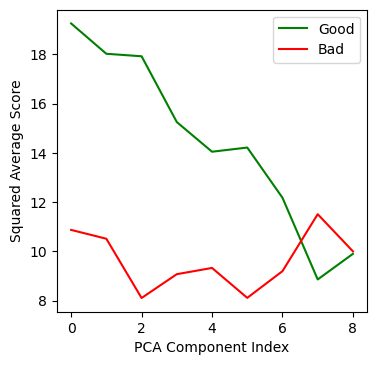

In [25]:
# Plot average projection onto components for each class
fig = plt.figure(figsize=(4,4), dpi=100)
plt.plot(list(range(n_components)), avg_good, 'g', label='Good')
plt.plot(list(range(n_components)), avg_bad, 'r', label='Bad')
plt.xlabel('PCA Component Index')
plt.ylabel('Squared Average Score')
plt.legend()

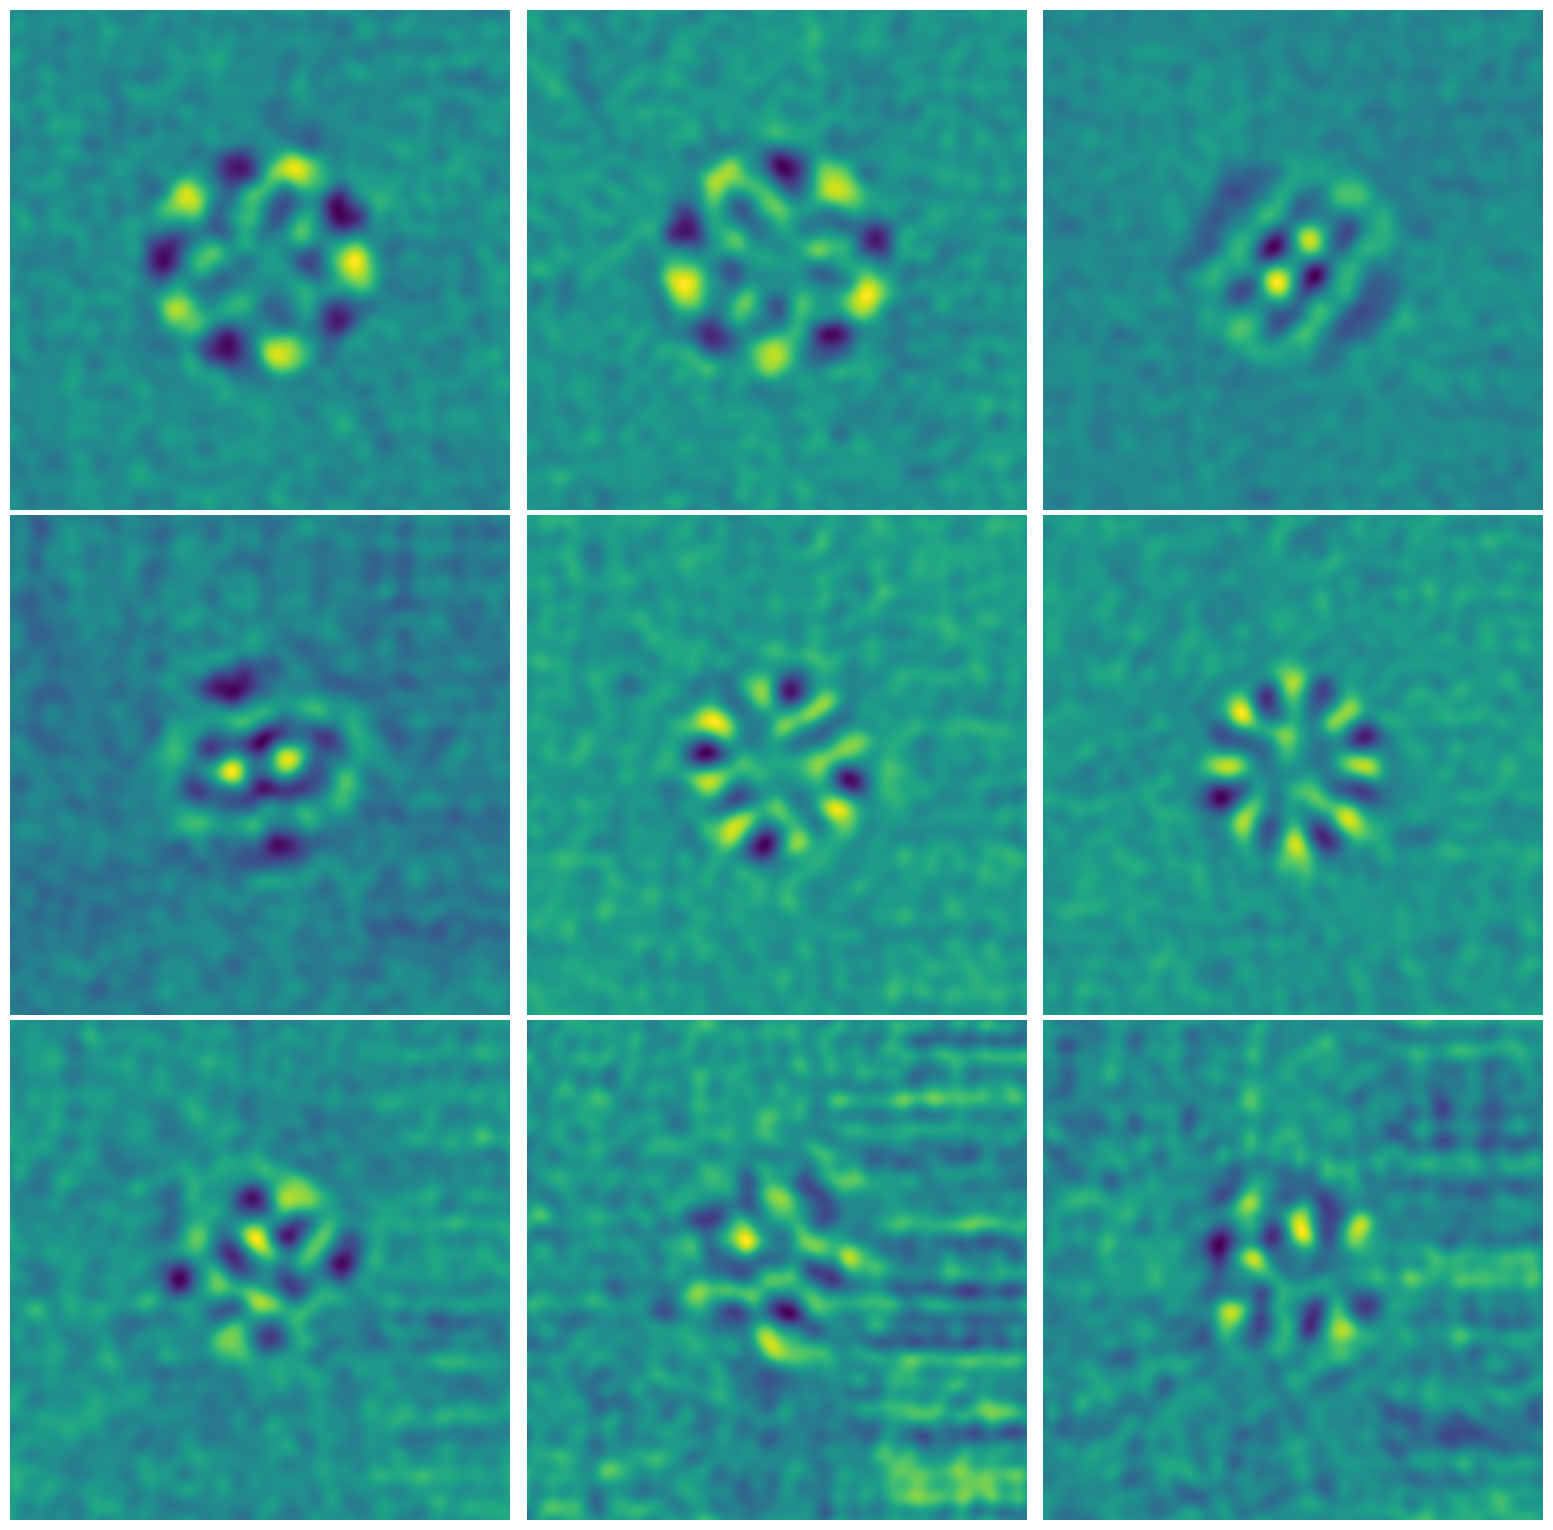

In [26]:
# Plot components
fig, axs = plt.subplots(3, 3, figsize=(20, 20), dpi= 100, gridspec_kw = {'wspace':0.0, 'hspace':0.01})

for i, ax in enumerate(fig.get_axes()):
    arr = arr_pca.components_[i,:]
    ax.imshow(arr.reshape(int(np.sqrt(arr.shape[0])), int(np.sqrt(arr.shape[0]))) )
    ax.axis('off')

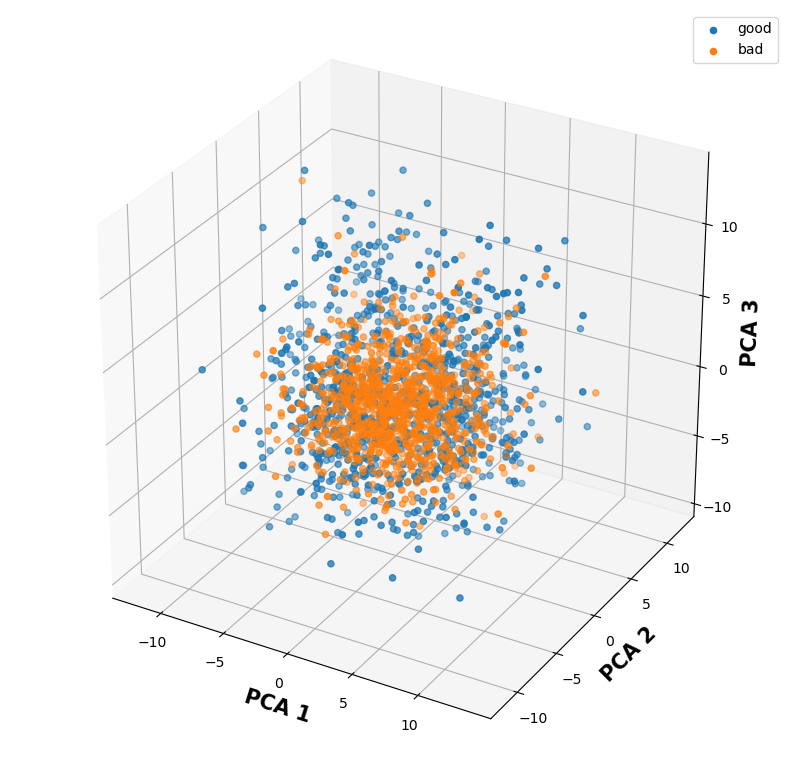

In [27]:
# 3D View of first 3 components
good_proj = proj_onto_components(flatten_stack(np.stack(data['good'], axis=0)), arr_pca.components_, use_abs_sq=False)
bad_proj = proj_onto_components(flatten_stack(np.stack(data['bad'], axis=0)), arr_pca.components_, use_abs_sq=False)

from mpl_toolkits.mplot3d import Axes3D 
fig = plt.figure(figsize=[10,10], dpi=100)
ax = fig.add_subplot(111, projection='3d')
ax.scatter(good_proj[0,:], good_proj[1,:], good_proj[2,:], marker='o', label='good')
ax.scatter(bad_proj[0,:], bad_proj[1,:], bad_proj[2,:], marker='o', label='bad')
ax.set_xlabel('PCA 1', fontsize=15, fontweight='bold')
ax.set_ylabel('PCA 2', fontsize=15, fontweight='bold')
ax.set_zlabel('PCA 3', fontsize=15, fontweight='bold')
plt.legend()
plt.show()

In [46]:
data = np.append(good_proj, bad_proj, axis=1)
labels = np.append(np.ones(good_proj.shape[1]), np.zeros(bad_proj.shape[1]))

with open('../data/dataset0/pca_proc.pkl', 'wb') as fb:
    pickle.dump((data, labels), fb)